In [1]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.optim.lr_scheduler as lr_scheduler

In [2]:
# Loading data

data = pd.read_csv("./dataset/anomaly-free.csv")

temperatures = data['Temperature'].values

In [3]:
# Checking data

print(data.head(5))

print(temperatures)
print(len(temperatures))
print(temperatures.shape)

           datetime  Accelerometer1RMS  Accelerometer2RMS  Current  Pressure  \
0  08/02/2020 13:30           0.206030           0.277924  1.81019  0.382638   
1  08/02/2020 13:30           0.204366           0.275727  2.66317 -0.273216   
2  08/02/2020 13:30           0.206103           0.278526  2.63758  0.382638   
3  08/02/2020 13:30           0.204775           0.276948  2.32851  0.382638   
4  08/02/2020 13:30           0.206052           0.278141  2.53422  0.382638   

   Temperature  Thermocouple  Voltage  Volume Flow RateRMS  
0      90.1740       26.7760  228.208              121.664  
1      90.2836       26.7760  227.245              122.000  
2      89.8666       26.7821  237.872              122.000  
3      90.2192       26.7773  230.422              121.338  
4      90.1449       26.7773  219.454              121.664  
[90.174  90.2836 89.8666 ... 89.2818 88.9028 89.088 ]
9401
(9401,)


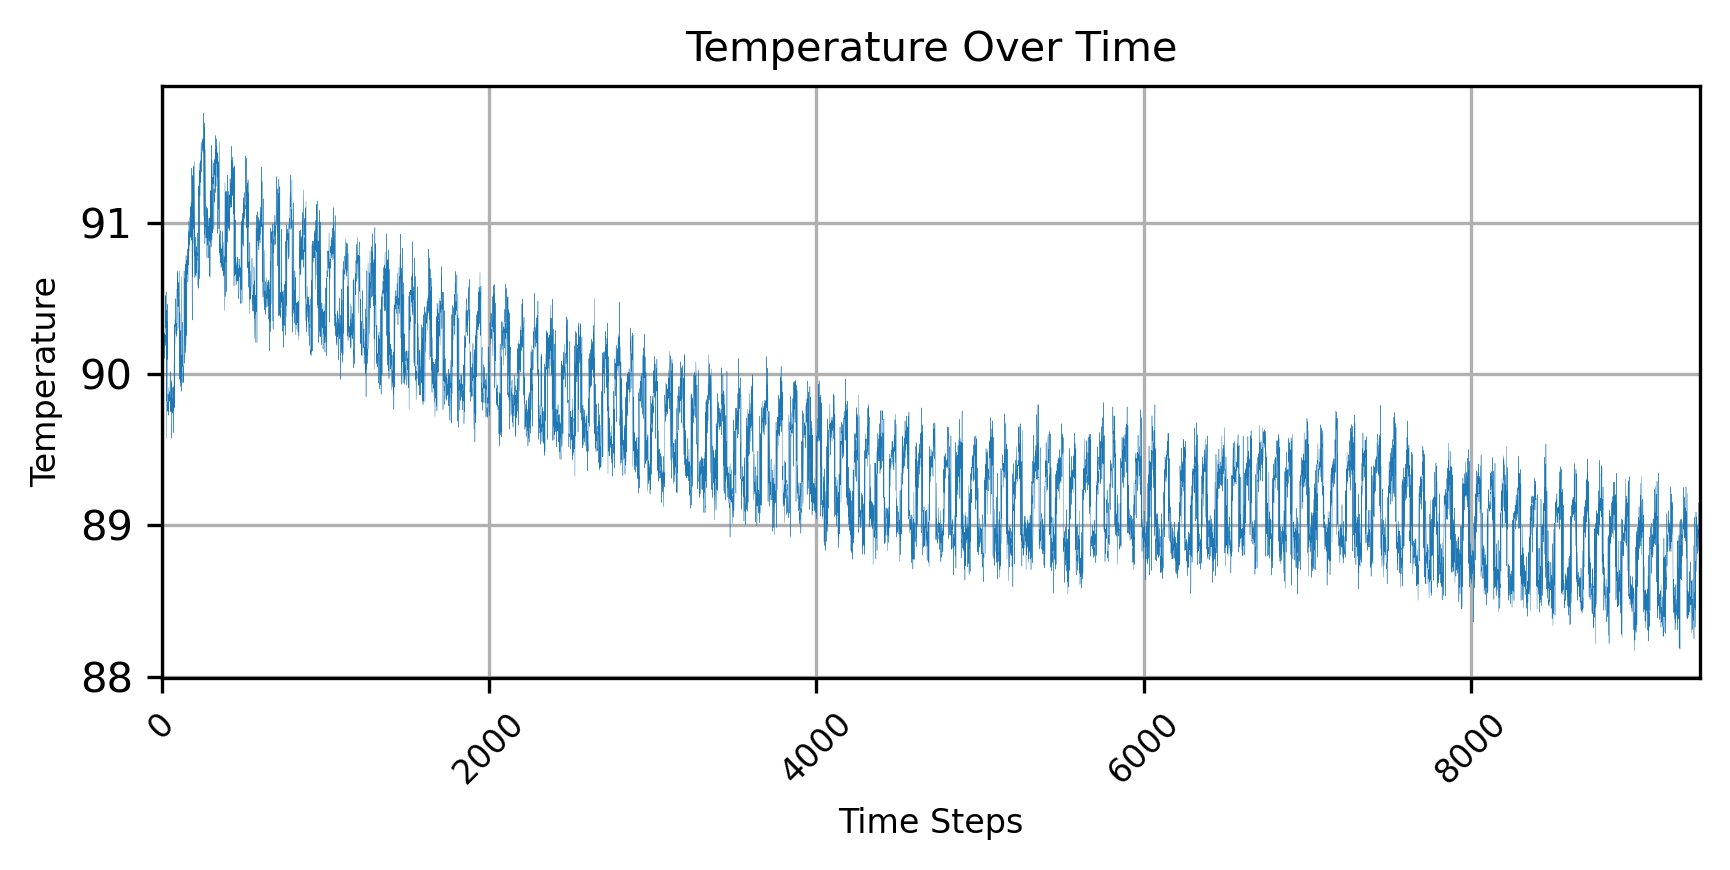

In [4]:
# Visualizing data

plt.figure(figsize=(6, 3), dpi=300)
plt.plot(data.index, data['Temperature'], linewidth=0.1)

plt.xlabel('Time Steps', fontsize=8)
plt.ylabel('Temperature', fontsize=8)
plt.title('Temperature Over Time', fontsize=10)

# Set major and minor ticks format
plt.grid()
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.xlim(0, data.index[-1])  # Replace max_value with your desired maximum
plt.show()


In [5]:
# Data normalization

scaler = MinMaxScaler()
temperatures_normalized = scaler.fit_transform(temperatures.reshape(-1, 1))
print(temperatures_normalized)
print(len(temperatures_normalized))
print(temperatures_normalized.shape)

[[0.56356934]
 [0.5944113 ]
 [0.47706551]
 ...
 [0.3125    ]
 [0.20584759]
 [0.25796376]]
9401
(9401, 1)


In [6]:
# Converting dataset into tensor

temperatures_tensor = torch.FloatTensor(temperatures_normalized)

# Ensure temperatures_tensor has shape (N,) and is reshaped correctly
temperatures_tensor = temperatures_tensor.view(-1)

# Create sequences (e.g., of length 50)
sequence_length = 50
sequenced_data = []
for i in range(len(temperatures_tensor) - sequence_length):
    sequenced_data.append(temperatures_tensor[i:i + sequence_length])

sequenced_data = torch.stack(sequenced_data)  # This will now have shape (num_samples, sequence_length)

# Create DataLoader
train_loader = DataLoader(sequenced_data.unsqueeze(1), batch_size=32, shuffle=True)  # Unsqueeze to match expected shape


In [7]:
sequenced_data.shape

torch.Size([9351, 50])

In [8]:
# Model configuration

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(sequence_length, 128),  # Ensure this matches your input size
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, sequence_length),
            nn.Sigmoid()  # Use Sigmoid to output values in range [0, 1]
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input for the linear layers
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the model
model = Autoencoder()

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Decays LR by 0.1 every 5 epochs

# Training
num_epochs = 15
for epoch in range(num_epochs):
    for data in train_loader:
        # Forward pass
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, data.view(data.size(0), -1))  # Flatten data for loss computation
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Step the scheduler
    scheduler.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, LR: {scheduler.get_last_lr()}')


Epoch [1/15], Loss: 0.0053, LR: [0.001]
Epoch [2/15], Loss: 0.0023, LR: [0.001]
Epoch [3/15], Loss: 0.0028, LR: [0.001]
Epoch [4/15], Loss: 0.0025, LR: [0.001]
Epoch [5/15], Loss: 0.0021, LR: [0.0001]
Epoch [6/15], Loss: 0.0020, LR: [0.0001]
Epoch [7/15], Loss: 0.0020, LR: [0.0001]
Epoch [8/15], Loss: 0.0019, LR: [0.0001]
Epoch [9/15], Loss: 0.0024, LR: [0.0001]
Epoch [10/15], Loss: 0.0024, LR: [1e-05]
Epoch [11/15], Loss: 0.0023, LR: [1e-05]
Epoch [12/15], Loss: 0.0029, LR: [1e-05]
Epoch [13/15], Loss: 0.0025, LR: [1e-05]
Epoch [14/15], Loss: 0.0017, LR: [1e-05]
Epoch [15/15], Loss: 0.0020, LR: [1.0000000000000002e-06]


Reconstructed shape: torch.Size([9351, 50])
Input shape: torch.Size([9351, 50])
Reconstruction Loss: 0.0510


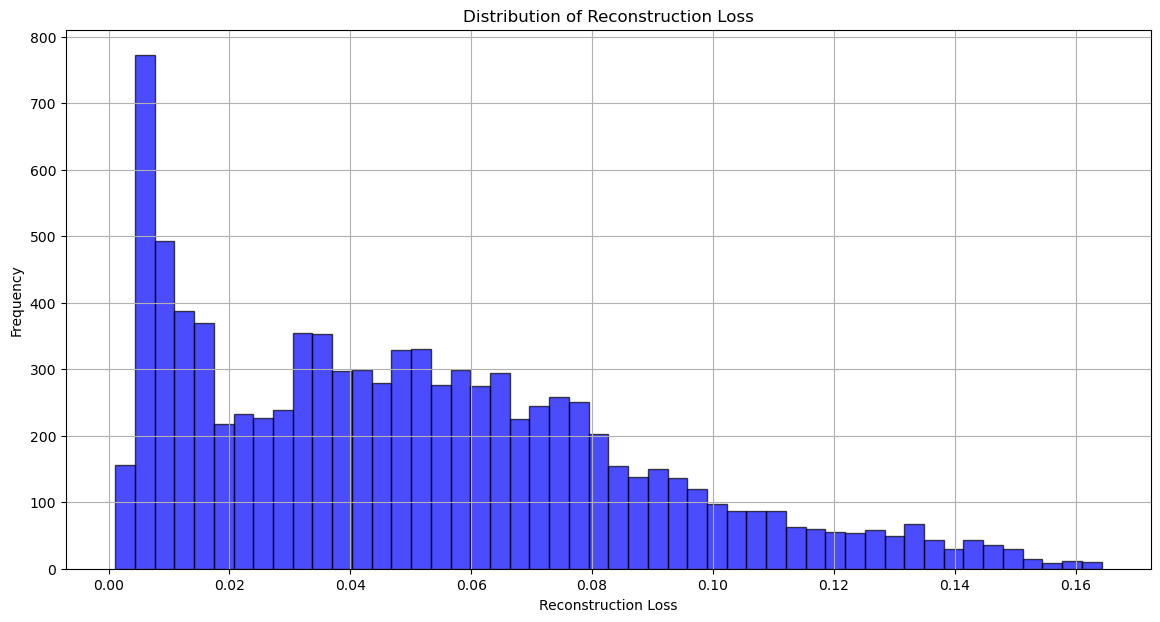

In [10]:
# Initialize the model and other components
model = Autoencoder()
criterion = nn.MSELoss()

# Switch to evaluation mode
model.eval()

# Evaluate the model
with torch.no_grad():
    reconstructed = model(sequenced_data.unsqueeze(1))  # Ensure X is of shape (batch_size, channels, sequence_length)

# Reshape for loss calculation
reconstructed_flat = reconstructed.view(reconstructed.size(0), -1)
X_flat = sequenced_data.view(sequenced_data.size(0), -1)

# Check shapes
print(f'Reconstructed shape: {reconstructed_flat.shape}')
print(f'Input shape: {X_flat.shape}')

# Calculate the reconstruction loss
try:
    # Ensure tensors are not empty
    if reconstructed_flat.size(0) == 0 or X_flat.size(0) == 0:
        raise ValueError("Reconstructed or input tensor is empty.")

    # Calculate loss
    loss = criterion(reconstructed_flat, X_flat)

    # Convert the loss tensor to a scalar
    loss_value = loss.item()  # Use .item() to get a Python float from a single-valued tensor

    # Print the loss value
    print(f'Reconstruction Loss: {loss_value:.4f}')

    # If you want to analyze individual losses, you need to compute them separately
    individual_losses = (reconstructed_flat - X_flat) ** 2  # Compute squared differences
    individual_losses = individual_losses.mean(dim=1)  # Mean across each sequence

    # Convert to NumPy for further processing
    individual_losses_np = individual_losses.cpu().detach().numpy()

    # Plot the distribution of individual losses
    plt.figure(figsize=(14, 7))
    plt.hist(individual_losses_np, bins=50, color='blue', alpha=0.7, edgecolor='black')
    plt.xlabel('Reconstruction Loss')
    plt.ylabel('Frequency')
    plt.title('Distribution of Reconstruction Loss')
    plt.grid()
    plt.show()

except Exception as e:
    print(f"Error in loss calculation: {e}")


In [11]:
print(max(individual_losses).numpy())

0.1643157


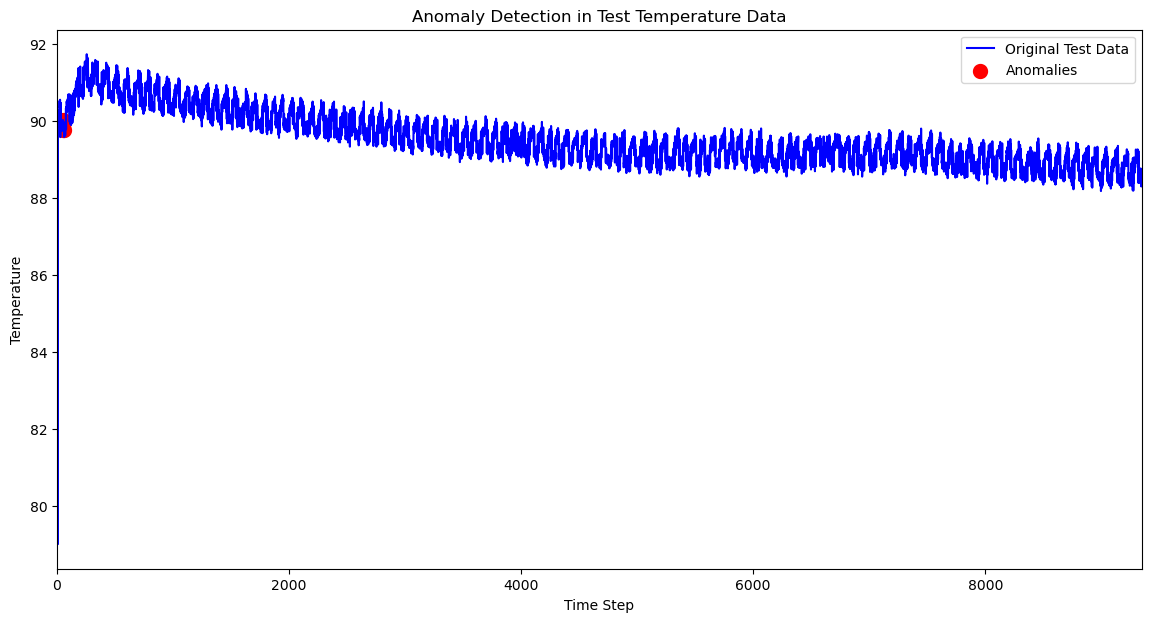

In [12]:
# Testing 1 (with anomalous data)

# Load your test data
test_data = pd.read_csv("./dataset/1.csv")  # Replace with your test data path
test_temperatures = test_data['Temperature'].values  # Adjust according to your CSV structure

# Normalize the test data using the same scaler
test_temperatures_normalized = scaler.transform(test_temperatures.reshape(-1, 1))

# Convert to tensor
test_temperatures_tensor = torch.FloatTensor(test_temperatures_normalized)

# Create test sequences
sequence_length = 50
X_test = []
for i in range(len(test_temperatures_tensor) - sequence_length):
    X_test.append(test_temperatures_tensor[i:i + sequence_length])

X_test = torch.stack(X_test)  # Shape (num_samples, sequence_length)

# Switch to evaluation mode
model.eval()

# Evaluate the model with no gradient tracking
with torch.no_grad():
    reconstructed_test = model(X_test.unsqueeze(1))  # Ensure correct shape

# Reshape for loss calculation
reconstructed_flat_test = reconstructed_test.view(reconstructed_test.size(0), -1)
X_flat_test = X_test.view(X_test.size(0), -1)

# Calculate the reconstruction loss
loss_test = criterion(reconstructed_flat_test, X_flat_test)

# Calculate individual losses for each sample
individual_losses_test = (reconstructed_flat_test - X_flat_test) ** 2  # Squared differences
individual_losses_test = individual_losses_test.mean(dim=1)  # Mean loss for each sequence

# Convert to NumPy for further processing
individual_losses_test_np = individual_losses_test.cpu().detach().numpy()

# Set a threshold for anomaly detection
threshold = max(individual_losses).numpy()  # Adjust based on distribution from training

# Identify anomalies
anomalies_test = individual_losses_test_np > threshold

# Extract indices where anomalies are detected
anomaly_indices_test = np.where(anomalies_test)[0] + sequence_length  # Offset by sequence_length

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(test_temperatures, label='Original Test Data', color='blue')

# Scatter plot for anomalies
plt.scatter(anomaly_indices_test, test_temperatures[anomaly_indices_test], color='red', label='Anomalies', linewidths=5)

plt.xlabel('Time Step')
plt.ylabel('Temperature')
plt.title('Anomaly Detection in Test Temperature Data')
plt.legend()
plt.xlim(0, len(X_test))
plt.show()


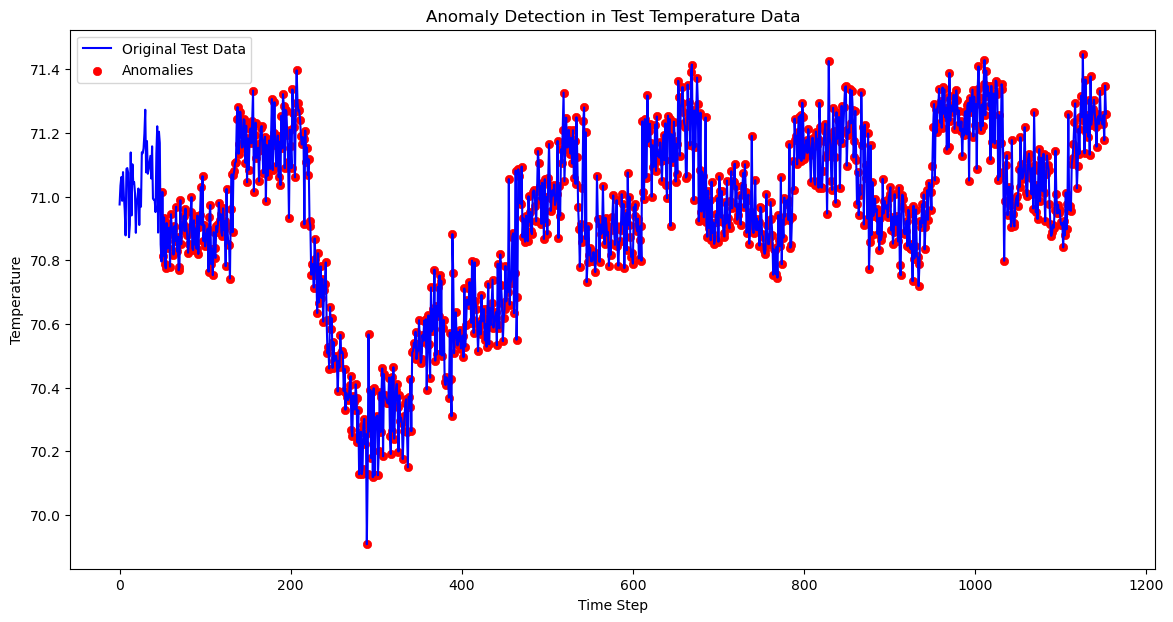

In [13]:
# Testing 2 (with anomalous data)

# Load your test data
test_data = pd.read_csv("./dataset/5.csv")  # Replace with your test data path
test_temperatures = test_data['Temperature'].values  # Adjust according to your CSV structure

# Normalize the test data using the same scaler
test_temperatures_normalized = scaler.transform(test_temperatures.reshape(-1, 1))

# Convert to tensor
test_temperatures_tensor = torch.FloatTensor(test_temperatures_normalized)

# Create test sequences
sequence_length = 50
X_test = []
for i in range(len(test_temperatures_tensor) - sequence_length):
    X_test.append(test_temperatures_tensor[i:i + sequence_length])

X_test = torch.stack(X_test)  # Shape (num_samples, sequence_length)

# Switch to evaluation mode
model.eval()

# Evaluate the model with no gradient tracking
with torch.no_grad():
    reconstructed_test = model(X_test.unsqueeze(1))  # Ensure correct shape

# Reshape for loss calculation
reconstructed_flat_test = reconstructed_test.view(reconstructed_test.size(0), -1)
X_flat_test = X_test.view(X_test.size(0), -1)

# Calculate the reconstruction loss
loss_test = criterion(reconstructed_flat_test, X_flat_test)

# Calculate individual losses for each sample
individual_losses_test = (reconstructed_flat_test - X_flat_test) ** 2  # Squared differences
individual_losses_test = individual_losses_test.mean(dim=1)  # Mean loss for each sequence

# Convert to NumPy for further processing
individual_losses_test_np = individual_losses_test.cpu().detach().numpy()

# Set a threshold for anomaly detection
threshold = 0.1665  # Adjust based on distribution from training

# Identify anomalies
anomalies_test = individual_losses_test_np > threshold

# Extract indices where anomalies are detected
anomaly_indices_test = np.where(anomalies_test)[0] + sequence_length  # Offset by sequence_length

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(test_temperatures, label='Original Test Data', color='blue')

# Scatter plot for anomalies
plt.scatter(anomaly_indices_test, test_temperatures[anomaly_indices_test], color='red', label='Anomalies', linewidths=0.5)

plt.xlabel('Time Step')
plt.ylabel('Temperature')
plt.title('Anomaly Detection in Test Temperature Data')
plt.legend()
plt.show()
